# The Sorting Hat 
The sorting hat assigns new witches and wizards into the houses that they will join for the remainder of their stay at Hogwarts. ![Sorting Hat](https://vignette.wikia.nocookie.net/harrypotter/images/6/62/Sorting_Hat.png/revision/latest?cb=20161120072849)Presumably, the Hat uses some **prior knowledge** to inform its decision of where a student will best fit in. From a Machine Learning perspective we could view this process as a **classification** task: given some **labeled** data (for example, information about previous Hogwarts students (the **data**) and which house they belonged to (the **label/class**)) can we build a model that can **predict** which house a new student belongs to. 

### In order to understand the magical ways of the Hat, we will perform the following:
1. Generate a dataset *...mmhhm...* I mean survey some previous Hogwarts students
2. Do some basic visualization to investigate how our features separate the classes
3. Teach a machine learning model about previous students
4. Predict your house and visualize where you stand relative to past students!

In an attempt to organize things a bit, I've put some functions in a script called [sortinghat_functions.py](https://github.com/michaelsilverstein/TheSortingHat/blob/master/sortinghat_functions.py)

# (1) Generate dataset
The Sorting Hat itself has been endowed with years upon years of knowledge about different students. Unforunately the Hat wasn't available to send me all of its data, so we will have to generate it ourself. In my opinion, generating datasets is a valuable exercise in and of itself. A machine learning dataset consists of a few components: **samples** (in this case, students), **features** (measured characteristics), and **class labels** (in this case, the house each student belonged to). In general, a machine learning **training set** (the dataset which contains previous measurements we wish to learn from), looks like this:

| Sample | Feature 1 | $\cdot\cdot\cdot$ | Feature N | Class |
| --- | --- | --- | --- | --- |
| Sample$_1$ | Observation$_{1,1}$ | $\cdot\cdot\cdot$ | Observation$_{1,N}$ | Class$_1$ |
|  $\cdot\cdot\cdot$ |  $\cdot\cdot\cdot$ | $\cdot\cdot\cdot$ | $\cdot\cdot\cdot$| $\cdot\cdot\cdot$ |
| Sample$_M$ | Observation$_{M,1}$ | $\cdot\cdot\cdot$ | Observation$_{M,N}$ | Class$_M$ |

Now, we have to imagine that the Sorting Hat has gathered information on all sorts of features, some of which will have more discriminatory power than others. For example, below is the height distribution of the students from each house. 
```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sortinghat_functions as sh
"""Generate height example"""
# List houses
houses = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']
palette = dict(zip(houses, ['red', 'gold', 'lightblue', 'green']))

# Assume same mean height, standard deviation, and class size for each house
mean_height = 5*12+7/12
std = 5
n = 20
# The seed for a random process establishes where the process "starts from". This allows us to 
# reproduce any random process, like sampling, which is used to generate the data
random_seed = 1

df = sh.generate_feature(mean_height, std, n, houses, 'height', random_seed)
g = sns.FacetGrid(df, hue='class', aspect=2.5, palette=palette)
g.map(sns.kdeplot, 'height', shade=True).add_legend(title='House')
plt.xlabel('Height (in)')
plt.yticks([])
plt.show()
```
![Height distribution](figures/height_dist.png) 

As we can see it doesn't seem like this feature (height) does not provide much discriminatory power between the different classes (as in, if all we knew about the students was their height we would have very little ability to distinguish which ones belonged to which house). Below we will generate data for some more features we believe the Hat may have observed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sortinghat_functions as sh

houses = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']
palette = dict(zip(houses, ['red', 'gold', 'lightblue', 'green']))

"""Let's generate data for some features!"""
# Choose features
features = ['height', 'bravery', 'criticality', 'Canadianness', 'scholar', 'kindness']
# Choose mean value for each feature (and for each house)
# Order maintained by `houses`
# `sh.generate_feature()` will apply single value to all classes if only one value passed
means = [5*12+7/12, [.8, .3, .4, .6], [.6, .2, .9, .4], [.3, .9, .5, .1], [.7, .6, .8, .6], [.7, .9, .6, .2]]
stds = [5, .2, [.3, .3, .1, .4], [.4, .1, .3, .1], .2, .2]
n = 20
random_seed = 123

# Generate data for each feature and save to a single dataframe
df = pd.DataFrame()
for feature, ms, ss in zip(features, means, stds):
    # We want all features (except height) to exist on a scale 0-1
    if feature != 'height':
        MIN, MAX = 0, 1
    else:
        MIN, MAX = None, None
    
    data = sh.generate_feature(ms, ss, n, houses, feature, random_seed, MIN, MAX)
    
    if df.empty:
        df = data
    else:
        df = df.join(data[feature])
# Place class label as last feature
df = df[[c for c in df if c!='class']+['class']]
# Let's rescale `height` between 0 and 1 so we can easily compare with other features
df['height'] = sh.rescale(df.height)
# Melt || Feat 1 | ... | Feat N | class || -> || feature | value | class ||
melted = df.melt('class', var_name='feature')
df.head()

,height,bravery,criticality,Canadianness,scholar,kindness,class
0,0.329989,0.582874,0.274311,0.000000,0.482874,0.482874,Gryffindor
1,0.731259,0.999469,0.899204,0.698938,0.899469,0.899469,Gryffindor
2,0.593642,0.856596,0.684894,0.413191,0.756596,0.756596,Gryffindor
3,0.248951,0.498741,0.148112,0.000000,0.398741,0.398741,Gryffindor
4,0.427665,0.684280,0.426420,0.068560,0.584280,0.584280,Gryffindor


# (2) Data visualization
Our features may capture differences independently, but likely there are higher order relationships that distinguish even better (interactions between multiple features that separate classes).

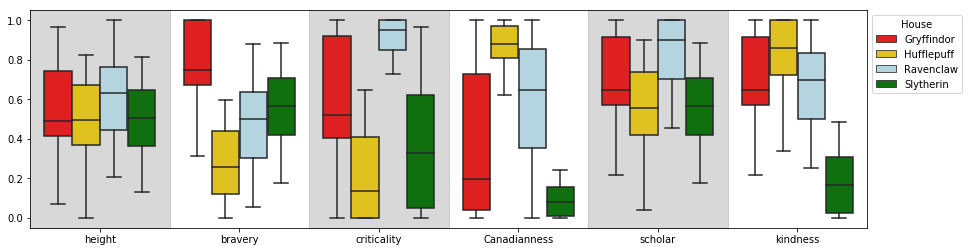

In [37]:
"""Visualize single features"""
# Set figure size
plt.figure(figsize=(15,4))
# Plot a boxplot of each feature colored by house (class)
sns.boxplot('feature', 'value', 'class', melted, palette=palette)
# Stripe every other feature for easier visualization
sh.zebra()
# Move legend to outside top right corner
plt.legend(bbox_to_anchor=(1,1), title='House')
# Turn off x and y labels
plt.ylabel('')
plt.xlabel('')
plt.show()